In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import numpy as np

### **Loading and Exploration**

In [82]:
df = pd.read_csv('data/data.csv')

C:\Users\gray-owl\AppData\Local\Temp\ipykernel_4608\2355141432.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/data.csv')


**Format column names**

In [83]:
# mettre les nom des colonnes sous forme de xxx-yyy
cols = df.columns.str.lower()
cols = cols.str.replace(r'\W', '-', regex=True)
cols = cols.str.replace(r'à', 'a', regex=True)
cols = cols.str.replace(r'é|è', 'e', regex=True)
df_clean = df.copy()
df_clean.columns = cols
df_clean.columns

Index(['titre', 'localisation', 'prix', 'annee-modele', 'boite-de-vitesses',
       'type-de-carburant', 'kilometrage', 'marque', 'modele',
       'nombre-de-portes', 'origine', 'premiere-main', 'puissance-fiscale',
       'etat', 'abs', 'airbags', 'cd-mp3-bluetooth', 'camera-de-recul',
       'climatisation', 'esp', 'jantes-aluminium', 'limiteur-de-vitesse',
       'ordinateur-de-bord', 'radar-de-recul', 'regulateur-de-vitesse',
       'sieges-cuir', 'systeme-de-navigation-gps', 'toit-ouvrant',
       'verrouillage-centralise-a-distance', 'vitres-electriques'],
      dtype='object')

**Suppression des colonnes**

In [84]:
cols = ['titre', 'localisation', 'nombre-de-portes']
df_clean = df_clean.drop(columns=cols)

**Nombre de valeurs nulles par attribut**

In [85]:
nulls_per_attr = df_clean.isna().sum().to_frame().where(lambda x: x > 0).dropna()
nulls_per_attr

,0
prix,463.0
annee-modele,559.0
boite-de-vitesses,706.0
type-de-carburant,557.0
kilometrage,570.0
marque,571.0
modele,571.0
origine,4585.0
premiere-main,5161.0
puissance-fiscale,723.0


**Suppression des lignes ayant tous les attributs nulls (à l'exception des attributs booleanes car il sont tous non nulls)**

In [86]:
df_clean = df_clean.dropna(subset=nulls_per_attr.index)
print(df_clean.shape)

(26951, 27)


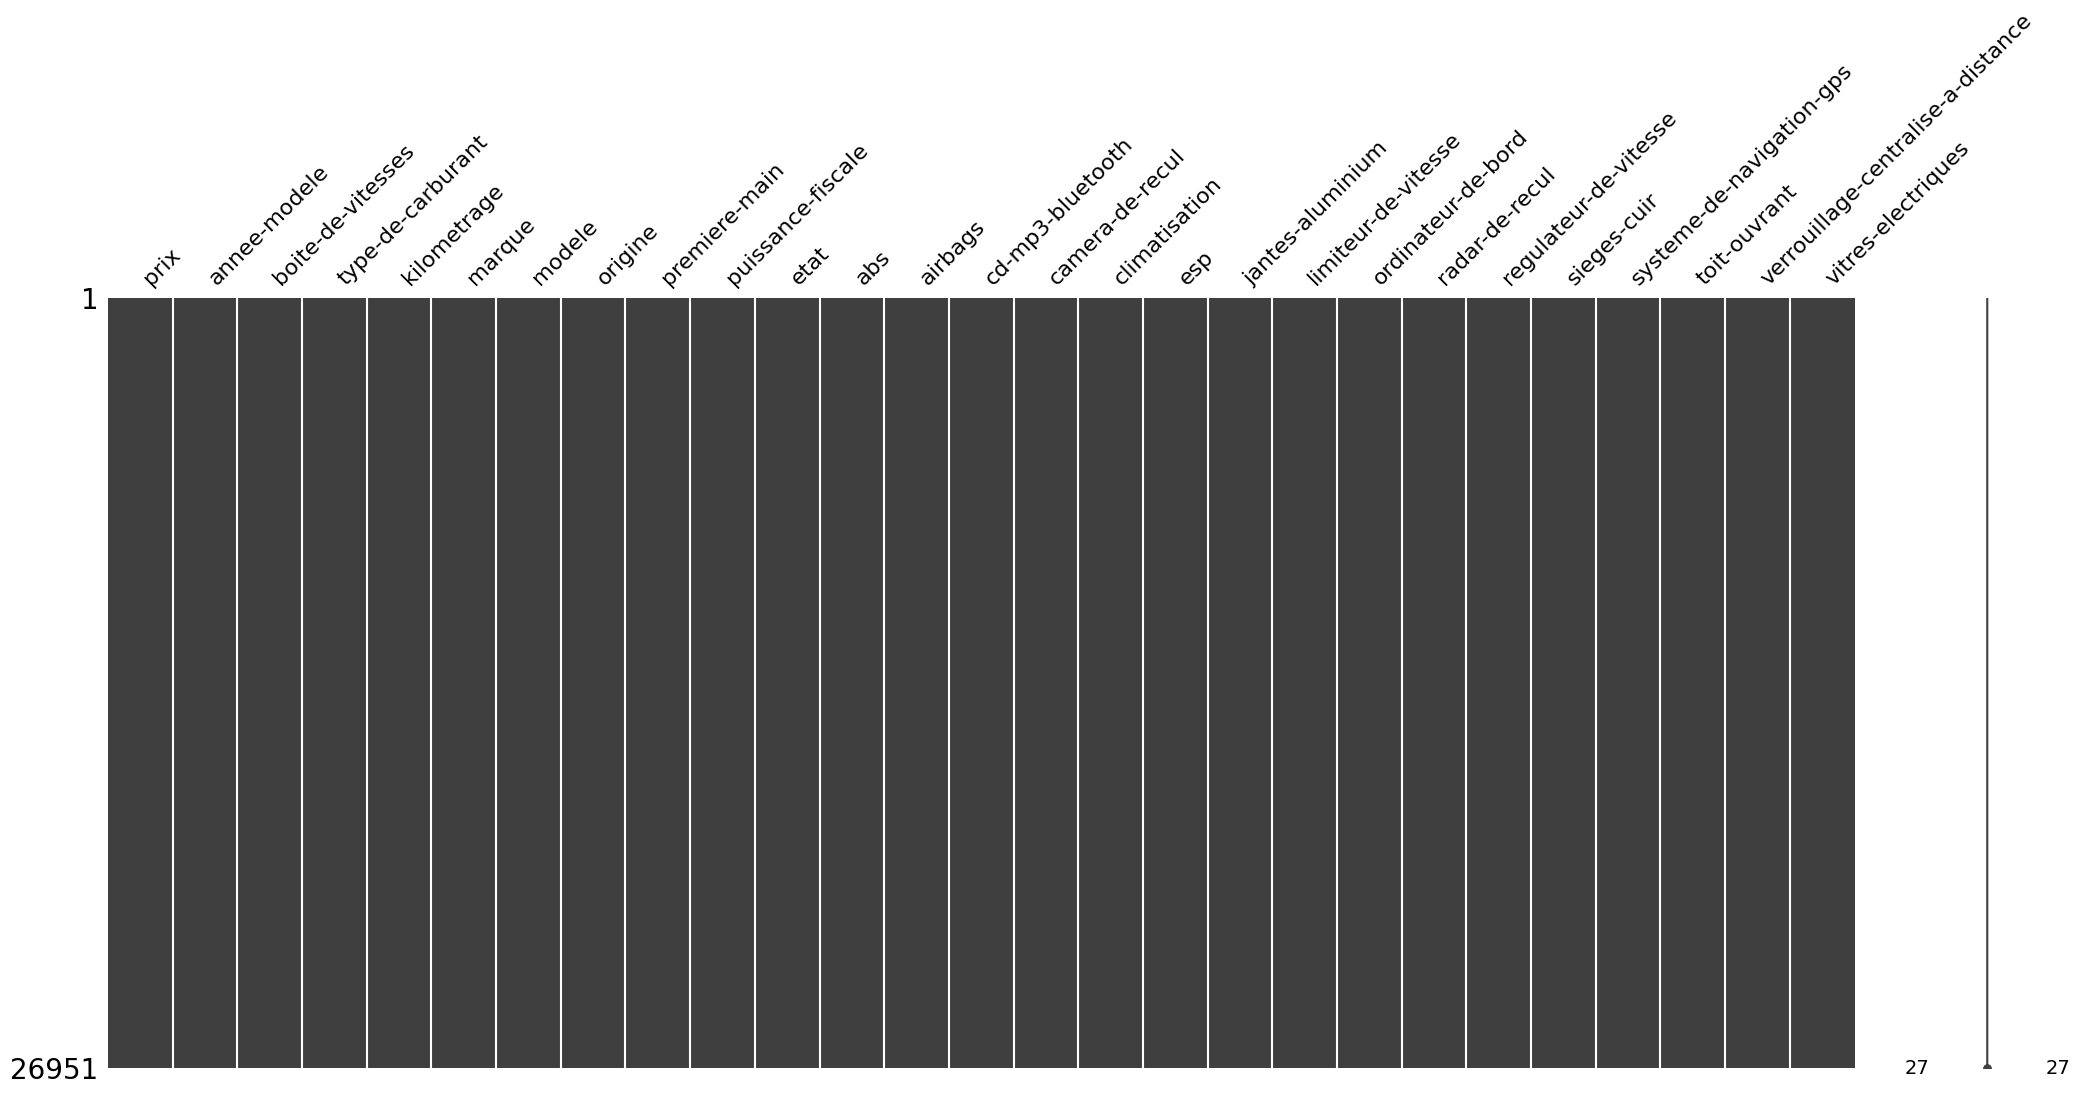

In [87]:
msno.matrix(df_clean);

In [88]:
print(f"Nombre de valeurs nulles : {df_clean.isna().sum().sum()}")

Nombre de valeurs nulles : 0


In [89]:
df_clean.sample()

,prix,annee-modele,boite-de-vitesses,type-de-carburant,kilometrage,marque,modele,origine,premiere-main,puissance-fiscale,...,jantes-aluminium,limiteur-de-vitesse,ordinateur-de-bord,radar-de-recul,regulateur-de-vitesse,sieges-cuir,systeme-de-navigation-gps,toit-ouvrant,verrouillage-centralise-a-distance,vitres-electriques
26005,33 000 DH,2000,Manuelle,Essence,250 000 - 299 999,Fiat,Siena,Dédouanée,Non,7 CV,...,False,False,False,False,False,False,False,False,True,True


### **Formattage des colonnes**

**Nettoyage de la colonne prix**

In [90]:
df_clean_prix = df_clean.copy()
df_clean_prix['prix'] = df_clean['prix'].str.replace(r'\D', '', regex=True)
df_clean_prix['prix'] = pd.to_numeric(df_clean_prix['prix'])
print(df_clean_prix['prix'].sample(2))

9746     19000
57      400000
Name: prix, dtype: int64


**Calcul du kilometrage moyen**

In [91]:
kilometrage_splited = df_clean_prix['kilometrage'].str.replace( r'\s', '', regex=True)
kilometrage_df = kilometrage_splited.str.extract(r'(\d+)-(\d+)')

kilometrage_df[0] = pd.to_numeric(kilometrage_df[0])
kilometrage_df[1] = pd.to_numeric(kilometrage_df[1])

df_clean_kilometrage = df_clean_prix.copy()
df_clean_kilometrage['kilometrage'] = kilometrage_df.mean(axis=1)

df_clean_kilometrage_no_nulls = df_clean_kilometrage.dropna(subset=['kilometrage'])
df_clean_kilometrage_no_nulls.sample()

,prix,annee-modele,boite-de-vitesses,type-de-carburant,kilometrage,marque,modele,origine,premiere-main,puissance-fiscale,...,jantes-aluminium,limiteur-de-vitesse,ordinateur-de-bord,radar-de-recul,regulateur-de-vitesse,sieges-cuir,systeme-de-navigation-gps,toit-ouvrant,verrouillage-centralise-a-distance,vitres-electriques
9103,135000,2015,Manuelle,Essence,72499.5,BMW,Série 1,WW au Maroc,Non,9 CV,...,True,True,True,True,False,False,True,False,True,True


**Convertir la puissance fiscale en un entier**

In [92]:
df_clean_puissance = df_clean_kilometrage_no_nulls.copy()

df_clean_puissance['puissance-fiscale'] = df_clean_kilometrage_no_nulls['puissance-fiscale'].str.replace(
    r'\D', '', regex=True)
df_clean_puissance['puissance-fiscale'] = pd.to_numeric(
    df_clean_puissance['puissance-fiscale'])
print(df_clean_puissance['puissance-fiscale'].dtype)

int64


**Formatter la colonne _annee-model_**

In [93]:
def extract_year(val):
    if isinstance(val, str):
        match = re.search(r'\d{4}', val)
        return int(match.group()) if match else np.nan
    elif isinstance(val, float) and not np.isnan(val):
        return int(val)
    elif isinstance(val, int):
        return val
    return np.nan


df_clean_puissance['annee-modele'] = df_clean_puissance['annee-modele'].apply(
    extract_year)

In [94]:
df_clean_annee_modele = df_clean_puissance.copy()
df_clean_annee_modele['annee-modele'] = pd.to_numeric(
    df_clean_puissance['annee-modele'])

**Premiere main**

In [95]:
# premiere main contient des valeurs 'oui' et 'non', convertir en booléen
df_clean = df_clean_annee_modele.copy()
df_clean['premiere-main'] = df_clean['premiere-main'].str.lower()
df_clean['premiere-main'] = df_clean['premiere-main'].replace(
    {'oui': True, 'non': False})

C:\Users\gray-owl\AppData\Local\Temp\ipykernel_4608\4211245815.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['premiere-main'] = df_clean['premiere-main'].replace(


#### **Data cleaned**

In [96]:
df_final = df_clean.copy()
df_final.to_csv('data/data_cleaned.csv', index=False)

### **Valeurs aberrantes**

Prix

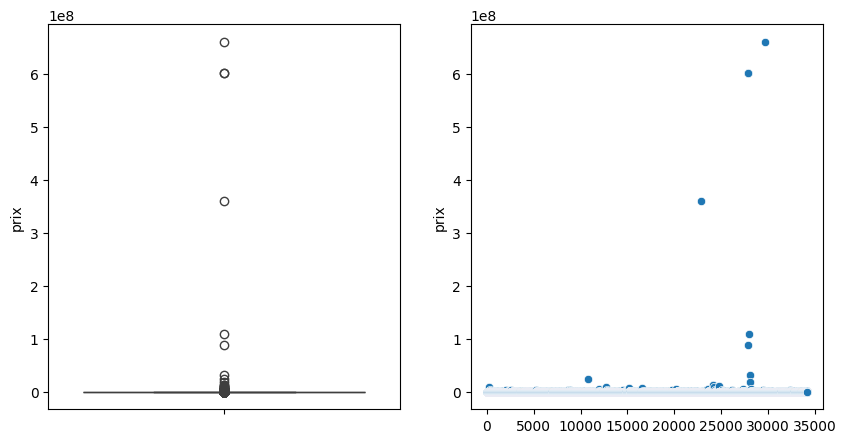

In [97]:
df = df_final.copy()
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(df, y='prix', ax=ax1);
sns.scatterplot(df['prix'], ax=ax2);

In [98]:
q1 = df['prix'].quantile(0.25)
q3 = df['prix'].quantile(0.75)
iqr = q3 - q1
min = q1 - 1.5 * iqr
max = q3 + 1.5 * iqr
df_clean_outliers = df[(df['prix'] >= min ) & (df['prix'] <= max)]
df_clean_outliers.shape

(25032, 27)

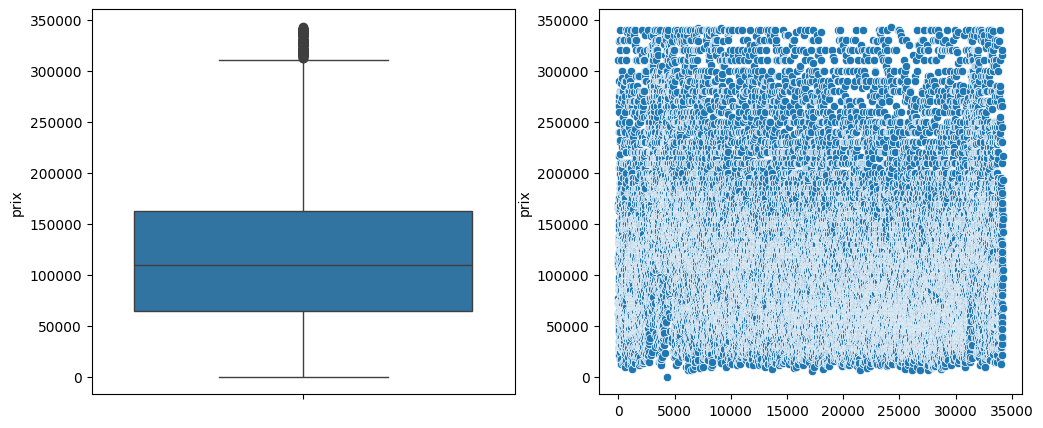

In [99]:
df = df_clean_outliers.copy()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df, y='prix', ax=ax1);
sns.scatterplot(df['prix'], ax=ax2);

**Kilometrage**

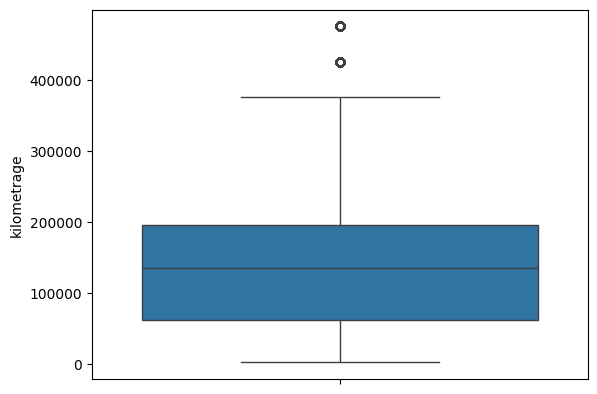

In [100]:
sns.boxplot(df, y='kilometrage');

In [101]:
q1 = df['kilometrage'].quantile(0.25)
q3 = df['kilometrage'].quantile(0.75)
iqr = q3 - q1
min = q1 - 1.5 * iqr
max = q3 + 1.5 * iqr
df_clean_outliers = df[(df['kilometrage'] >= min) & (df['kilometrage'] <= max)]
df_clean_outliers.shape

(24695, 27)

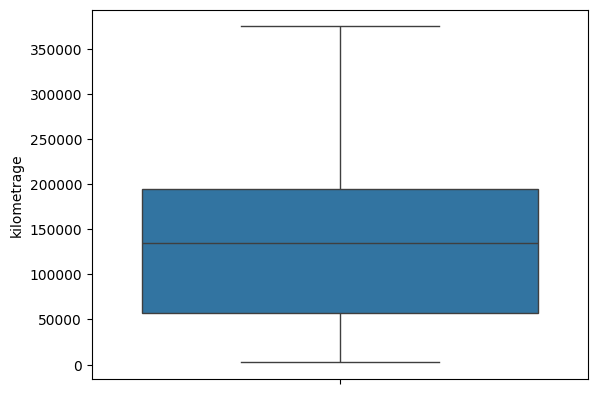

In [102]:
df = df_clean_outliers.copy()
sns.boxplot(df, y='kilometrage');

In [103]:
df.shape

(24695, 27)

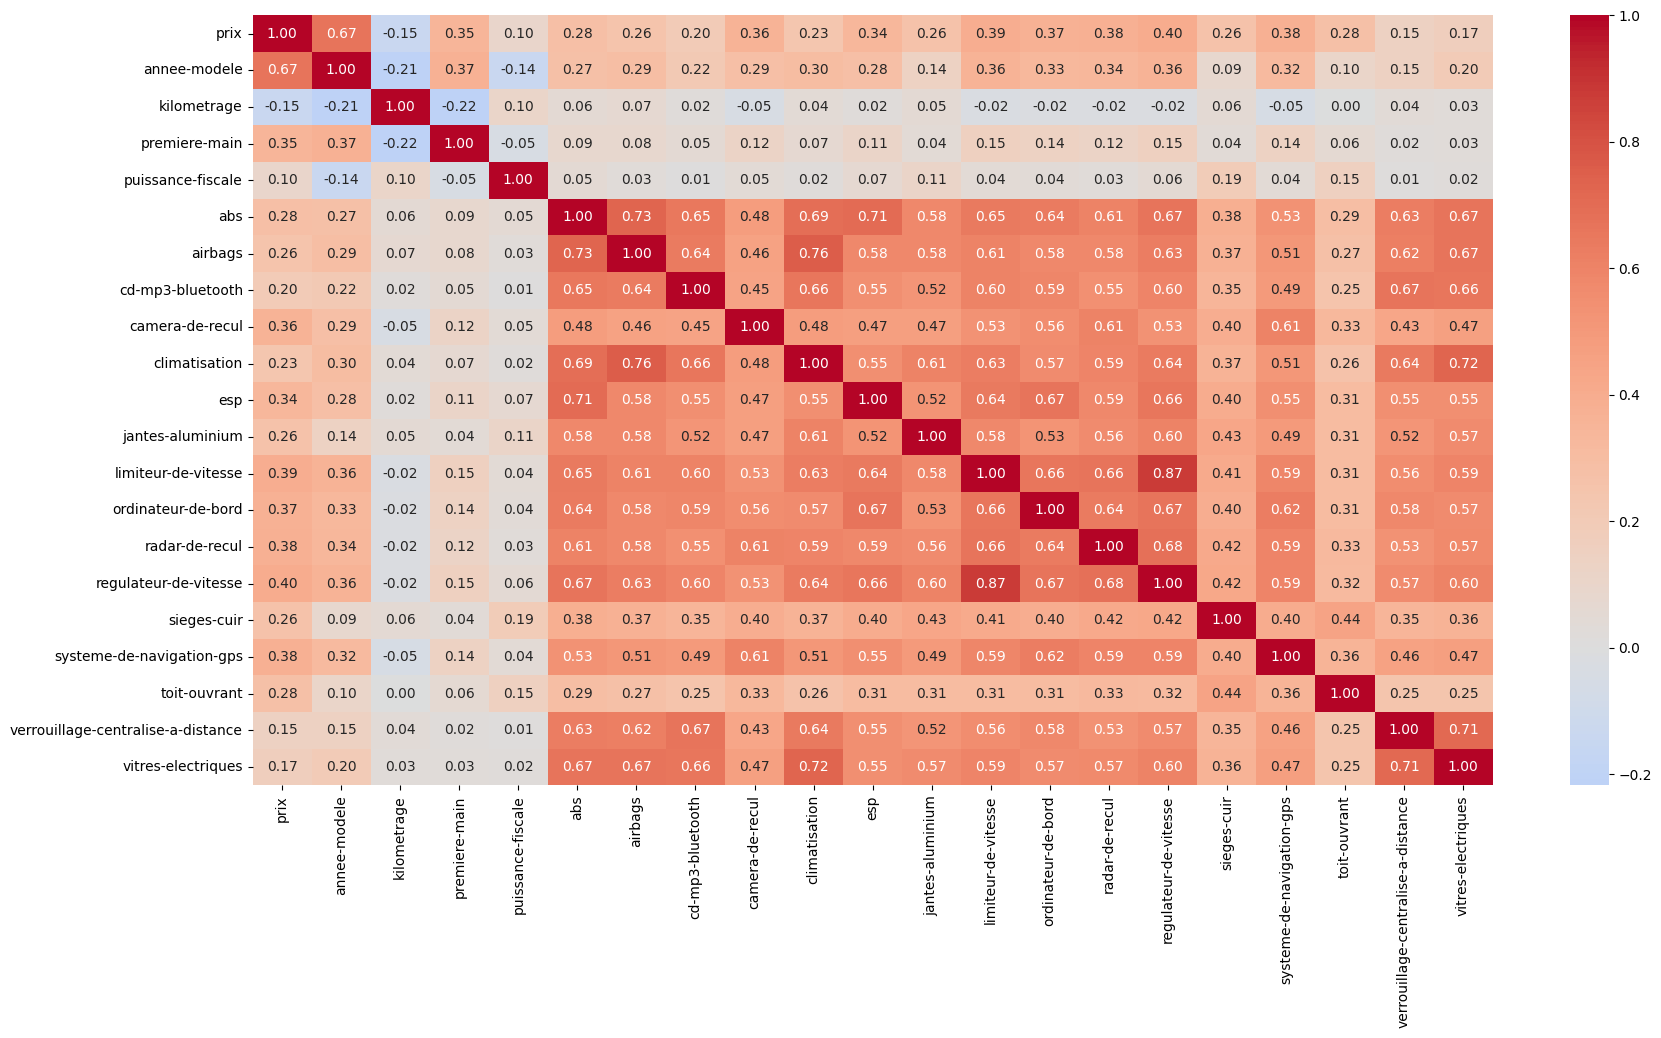

In [104]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', center=0);